In [37]:
from pathlib import Path
import argparse

import torch
from torch import nn
from skimage import io

from emonet.models import EmoNet

import cv2

# torch.backends.cudnn.benchmark =  True

# #Parse arguments
# parser = argparse.ArgumentParser()
# parser.add_argument('--nclasses', type=int, default=8, choices=[5,8], help='Number of emotional classes to test the model on. Please use 5 or 8.')
# parser.add_argument('--image_path', type=str, default="images/example.png", help='Path to a face image.')
# args = parser.parse_args()

# Parameters of the experiments
n_expression = 8
#device = 'cuda:0'
device = 'cpu'
image_size = 256
emotion_classes = {0:"Neutral", 1:"Happy", 2:"Sad", 3:"Surprise", 4:"Fear", 5:"Disgust", 6:"Anger", 7:"Contempt"}
#image_path = Path(__file__).parent / args.image_path
image_path = "/Users/zhengyuanrui/IMG_8004.JPG"
# Loading the model 
state_dict_path = "/Users/zhengyuanrui/face/emonet/pretrained/emonet_8.pth"

print(f'Loading the model from {state_dict_path}.')
state_dict = torch.load(str(state_dict_path), map_location='cpu')
state_dict = {k.replace('module.',''):v for k,v in state_dict.items()}
net = EmoNet(n_expression=n_expression).to(device)
net.load_state_dict(state_dict, strict=False)
net.eval()

print(f'Testing on a single image')
print(f'------------------------')
# Load image in RGB format
image_rgb = io.imread(image_path)[:,:,:3]

# Resize image to (256,256)
image_rgb = cv2.resize(image_rgb, (image_size, image_size))

# Load image into a tensor: convert to RGB, and put the tensor in the [0;1] range
image_tensor = torch.Tensor(image_rgb).permute(2,0,1).to(device)/255.0

def register_hooks(model, target_layers):
    """
    注册钩子以从指定层提取特征。
    """
    if not isinstance(target_layers, list): 
        target_layers = [target_layers]
    # 定义一个字典，键是层的名字，值是层的输出
    features = {}

    def get_hook(name):
        def hook(module, input, output):
            features[name] = output.detach()
        return hook

    # 为指定层注册钩子
    for name, layer in model.named_modules():
        if name in target_layers:
            layer.register_forward_hook(get_hook(name))
    
    return features
features = register_hooks(net, target_layers = ["conv1", "emo_net_2.0.conv1", "avg_pool_2"])

with torch.no_grad():
    output = net(image_tensor.unsqueeze(0))
    predicted_emotion_class = torch.argmax(nn.functional.softmax(output["expression"], dim=1)).cpu().item()
    
    # Expected output on example image: Predicted Emotion Happy - valence 0.064 - arousal 0.143
    print(f"Predicted Emotion {emotion_classes[predicted_emotion_class]} - valence {output['valence'].clamp(-1.0,1.0).cpu().item():.3f} - arousal {output['arousal'].clamp(-1.0,1.0).cpu().item():.3f}")

Loading the model from /Users/zhengyuanrui/face/emonet/pretrained/emonet_8.pth.
Testing on a single image
------------------------
Predicted Emotion Anger - valence -0.377 - arousal 0.419


In [46]:
import matplotlib.pyplot as plt
import torch

def plot_feature(features, layer, idx):
    # 提取特征并计算平均
    feature = torch.mean(features[layer], dim=1)  # 对通道进行平均
    first_item = feature[idx].cpu().clone()  # 选择特征图的索引，确保在 CPU 上处理

    plt.figure(figsize=(8, 8))  # 设置图像大小

    # 可视化单个特征图
    plt.axis('off')  # 不显示坐标轴
    plt.imshow(first_item.detach().numpy(), cmap='gray')  # 使用 gray cmap 可视化
    
    plt.title(f'Feature Map for Layer: {layer}, Index: {idx}')  # 添加标题
    plt.show()  # 显示图


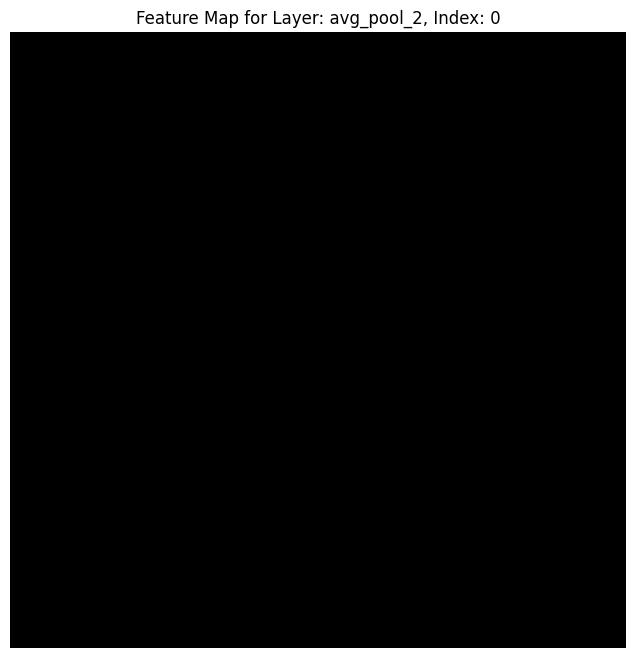

In [47]:
plot_feature(features, 'avg_pool_2', 0)

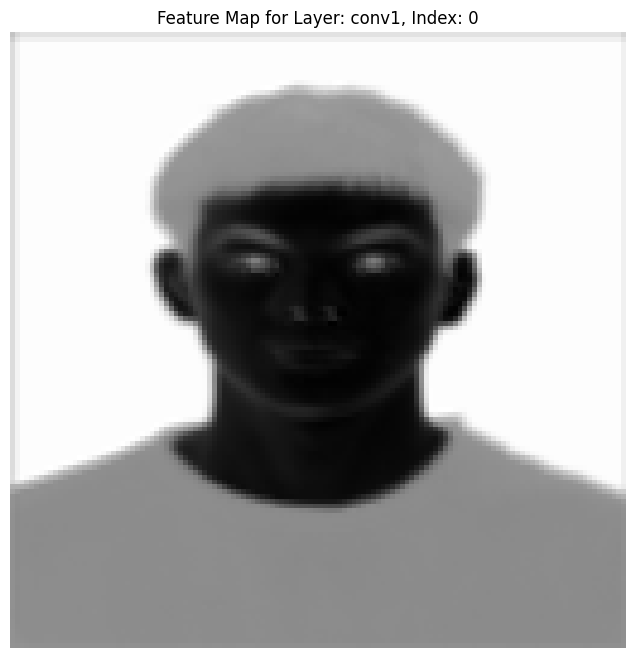

In [48]:
plot_feature(features, 'conv1', 0)

In [49]:
features["emo_net_2.0.conv1"].shape

torch.Size([1, 128, 64, 64])

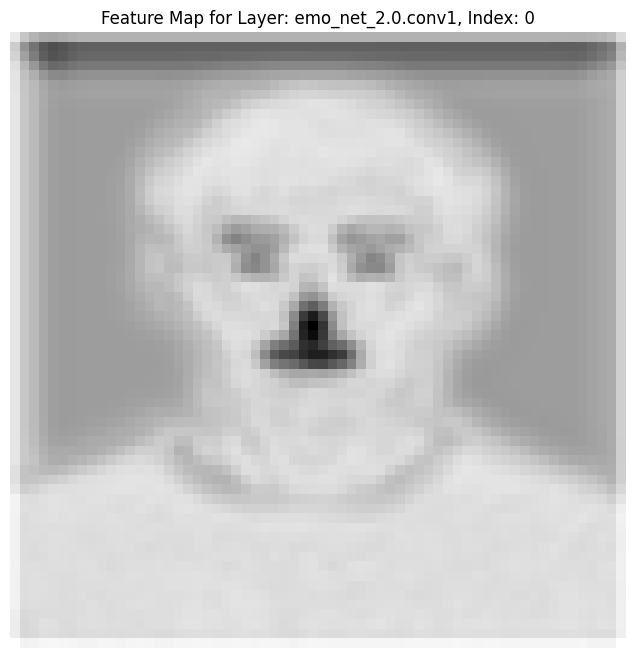

In [50]:
plot_feature(features, "emo_net_2.0.conv1", 0)
